# Visualize Todos

To filter, set demo_tids to a list of tids. To avoid filtering, set demo_tids to an empty list.  

Run the notebook and see your tasks laid out!

In [1]:
import datetime
from collections import namedtuple
import sys
import os

sys.path.append(os.path.abspath('..'))
from todos.todos_config import connection_string, schema_name, demo_tids
from todos.utils import get_connection
from todos.commands import view_queries

from IPython.display import display, HTML
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
one_week = datetime.timedelta(days=7)

In [21]:
def importance_to_hexcolor(i, scale=10):
    r = i/scale*255
    g = (scale-i)/scale*255
    b = 0
    hexcolor = '#' + ''.join([
        '{:>02}'.format(hex(int(v)).split('x')[-1])
        for v in (r, g, b)
    ])
    return hexcolor
importance_to_hexcolor(0), importance_to_hexcolor(10)

('#00ff00', '#ff0000')

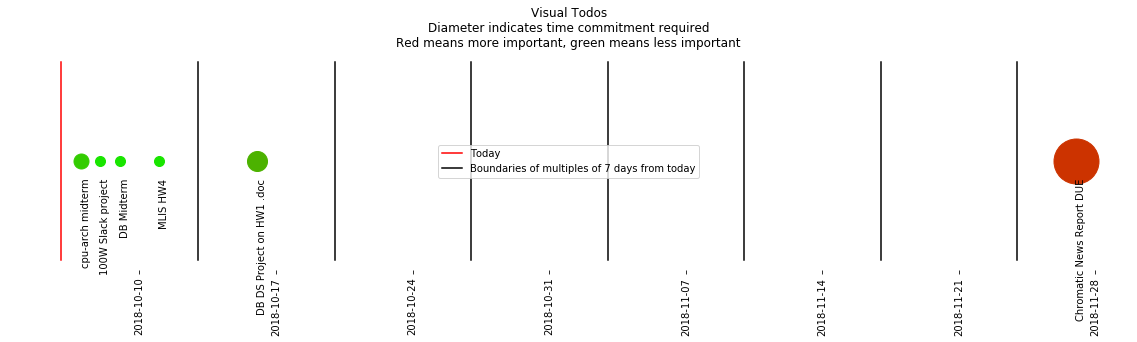

In [27]:
plt.figure(figsize=(20,4))
with get_connection(connection_string) as (conn, cursor):
    cursor.execute("""SELECT
            *
            , coalesce(time_commitment, 1) as time_commitment2
        FROM todos
        WHERE tid = ANY(%(demo_tids)s)

        -- plot large circles on the graph first, so smaller ones that
        -- overlap will be placed on top of those instead of beneath
        ORDER BY time_commitment2 DESC
    """, vars={'demo_tids': demo_tids})
    headers = [c.name for c in cursor.description]
    Todo = namedtuple('Todo', headers)
    max_duetime = datetime.datetime.today()
    for row in cursor:
        todo = Todo(*row)
        if todo.due_time is None:
            continue
        max_duetime = max(max_duetime, todo.due_time)
        x = [todo.due_time]
        y = [0]
        plt.plot_date(
            x, y,
            'o',
            color=importance_to_hexcolor(todo.time_commitment2),
            markersize=(todo.time_commitment2+1)*5,
        )
        plt.text(x[0], -.01, todo.title, rotation=90)
    plt.xticks(rotation=90)

# today indicator: make a vertical line indicating today (different color from other weeks)
today = datetime.date.today()
day = datetime.datetime(today.year, today.month, today.day)
y = [-.04, .04]
plt.plot_date([day, day], y, 'r-', label='Today')
day += one_week

# week indicators: make vertical black lines each week following today
kwargs = {'label': 'Boundaries of multiples of 7 days from today'}
while day < max_duetime:
    plt.plot_date([day, day], y, 'k-', **kwargs)
    kwargs = dict()
    day += one_week

plt.legend()
plt.title('\n'.join([
    "Visual Todos",
    "Diameter indicates time commitment required",
    "Red means more important, green means less important",
]))
plt.gca().set_frame_on(False)
plt.yticks(tuple())
None

In [30]:
title_html = '''
    <span style="color:#A3A; font-size:20px; font-weight:bold; margin-left:100px">
        {}
    </span>
'''
with get_connection(connection_string) as (conn, cursor):
    for qname, view_query in view_queries:
        display(HTML(title_html.format(qname.title())))
        view_query = view_query.format(schema=schema_name)
        if demo_tids:
            view_query = view_query.lower().replace('where', 'where tid =ANY(%(demo_tids)s) and')

        df = pd.read_sql(view_query, con=conn, params={'demo_tids': demo_tids}).fillna('')
        display(df.set_index(df.columns[0]))

,title
due_time,
2018-10-07,cpu-arch midterm
2018-10-08,100W Slack project
2018-10-09,DB Midterm
2018-10-11,MLIS HW4
2018-10-16,DB DS Project on HW1 .doc


,title,due_time
person_waiting,,
Jay,Chromatic News dataset,
Debra,100W Slack project,2018-10-08 00:00:00


,title
time_commitment,
2,~/Desk/food.xlsx data project
2,cpu-arch midterm
3,update mac OS
3,DB DS Project on HW1 .doc
3,Chromatic News dataset


,title
time_commitment,
8,Chromatic News Report DUE


,title
life_importance,
7,call grandpa


,title,due_time
career_importance,,
10,Chromatic News dataset,
10,Chromatic News Report DUE,2018-11-27 00:00:00
8,MLIS HW4,2018-10-11 00:00:00
5,cpu-arch midterm,2018-10-07 00:00:00
